# Cosmology with LSST

Our goal is to constrain cosmological parameters with LSST using galaxy shapes and galaxy positions. We know these observables are sensitive to the growth and expansion history of the Universe. While we cannot predict where a given galaxy will form in the Universe, we can predict, given a cosmological model, the statistics of how galaxy pairs are distributed, and of how galaxy shapes relate to galaxy positions and to one another. In this example, we are going to choose a cosmological model and we are going to plot the angular correlations of those observables.

# Using the Core Cosmology Library (CCL)

The first thing to do will be to be able to call the library from this notebook. For that, we are going to import it as we import any other module.

In [1]:
import pyccl as ccl

Let's also import some additional modules we will need. These are standard ones that come with python.

In [2]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

We now need to decide which cosmology we are going to be working with. Let's start with a flat LCDM cosmology:

In [3]:
cosmo_fid = ccl.Cosmology(Omega_c=0.222, Omega_b=0.045, h=0.71, sigma8=0.806, n_s=0.963)

Let's see what's inside this object. It contains all the parameters that CCL needs to perform its computations. Because we haven't provided all of them, CCL is making some assumptions about what values to adopt. 

In [4]:
print(cosmo_fid)

pyccl.Cosmology(Omega_c=0.222, Omega_b=0.045, h=0.71, n_s=0.963, sigma8=0.806, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1.0, wa=0.0, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, m_nu=0.0, mnu_type=None, z_mg=None, df_mg=None, transfer_function='boltzmann_class', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')


# Defining our sample of galaxies

With this cosmology in place, we can make CCL give us some basic computations. To do this, we are going to have to decide at what redshift we need to evaluate the functions. For the observables we are interested in, we expect that LSST will roughly cover the range between 0<z<3. 

In [5]:
nz = 25
z = np.linspace(0.1,3.,nz)

The galaxies that we are observing have some redshift distribution, and it is through these galaxies that we plan to constrain cosmology. To illustrate our example, we are going to assume we have the same sample to probe galaxy shapes and galaxy positions, and we'll use pre-defined redshift distributions for this. (We can't measure the shapes for all galaxies for which we have positions, so usually the first will be a fraction of the second.) You could, if you wanted, pass your own redshift distribution to CCL.

In [6]:
import scipy.integrate

def pz_tot(z, alpha=1.24, beta=1.01, z0=0.51):
    """Smail et al. 1994 redshift dist"""
    return np.power(z, alpha) * np.exp(-np.power(z/z0, beta))

def photoz_dist(z_photo, z_true, sigma_z0=0.05):
    return (
        np.exp(-0.5 * np.power((z_photo - z_true) / sigma_z0 / (1 + z_true), 2)) / 
        np.sqrt(2.0 * np.pi) / 
        sigma_z0 / (1 + z_true))


def pz_joint(z_photo, z_true):
    return pz_tot(z_true) * photoz_dist(z_photo, z_true)


denom, _ = scipy.integrate.dblquad(
    pz_joint,
    # range in z_true (second arg to pz_joint)
    0, 5,
    # range in z_photo (first argument to pz_joint) as a function of z_true
    lambda x: 0.1, lambda x: 3.0)

dndz = []
for _z in z:
    val, _ = scipy.integrate.quad(pz_joint, 0.1, 3.0, args=(_z,))
    dndz.append(val / denom)
dndz = np.array(dndz)

Let's take a look at the redshift distribution we have defined:

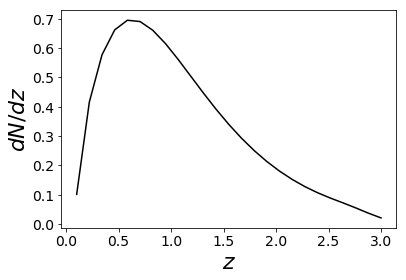

In [7]:
plt.plot(z, dndz, 'k-')
plt.xlabel(r'$z$', fontsize=22)
plt.ylabel(r'$dN/dz$', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# 3x2 correlations with CCL

With two samples of galaxies, there are three types of correlations we can perform. We could measure and model the auto-correlations of galaxy positions ("clustering"), the auto-correlations of galaxy shapes ("cosmic shear") and the cross-correlation between positions and shapes. Normally, to gain information on the expansion history of the Universe, we would split the sample into different redshift bins with a sufficient number of galaxies to have a significant measurement in each one. But for now, let's just take the full redshift distribution.

Correlations are expressed in different forms. Here, we are going to express them in terms of "angular power spectra", or C_ell. Imagine that we took the sphere of the sky and expanded any function of the coordinates of the sphere into a basis of spherical harmonics. Each harmonic would contribute to the expansion with a given amplitude. What we are going to plot is the square of that amplitude as a function of multipole index.

## Galaxy positions

To model galaxy positions we need to define a "bias" parameter. This parameter tells us how the galaxies are connected to the density field. To make it simple, we'll take a one-to-one relation. Galaxies are simply tracing the density field in this model:

In [8]:
bias_gal = np.ones(z.size)

We know need to define a convenience function, called a "tracer" which will store this information. 

In [9]:
gal_pos = ccl.NumberCountsTracer(cosmo_fid, has_rsd=False, dndz=(z, dndz), bias=(z, bias_gal))

The "False" statements above control the modeling of potential contributions to the signal, like redshift-space distortions.

In [10]:
gal_shapes = ccl.WeakLensingTracer(cosmo_fid, dndz=(z, dndz))

## Angular power spectra

We are now ready to compute angular power spectra, C_ell. These are a function of multipole number, with high ell correponding to small scales on the sky and low ell, to large separations on the sky.

In [11]:
ell = np.arange(100, 5000)
cls_auto_pos = ccl.angular_cl(cosmo_fid, gal_pos, gal_pos, ell)
cls_auto_shape = ccl.angular_cl(cosmo_fid, gal_shapes, gal_shapes, ell)
cls_pos_shape = ccl.angular_cl(cosmo_fid, gal_pos, gal_shapes, ell)

We know have three correlations we can plot, and which we can fit to our observables. Varying the cosmology will result in these curves changing shape and moving up and down. See our likelihood notebook for an example of how to make fits to your data.

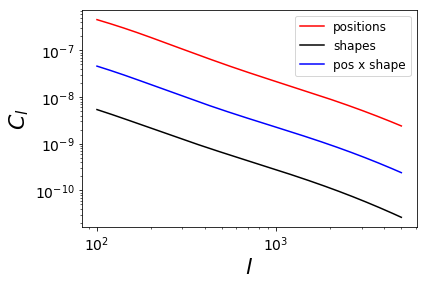

In [12]:
plt.plot(ell, cls_auto_pos, 'r-', label='positions')
plt.plot(ell, cls_auto_shape, 'k-', label='shapes')
plt.plot(ell, cls_pos_shape, 'b-', label='pos x shape')
plt.legend(loc='upper right', prop={'size':12})
plt.xlabel(r'$l$', fontsize=22)
plt.ylabel(r'$C_l$', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.show()